In [ ]:
import cv2
import numpy as np
import torch
from PIL import Image
import psutil
import shutil
from tqdm import tqdm
import os
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor, SahiAutoSegmentation, sahi_sliced_predict
from segment_anythingss import sam_model_registry, SamPredictor
from yolov5m.detect import YOLODetector
from tracking import TrackingAnything

sam_checkpoint = "vit_h.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

def get_frames_from_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            current_memory_usage = psutil.virtual_memory().percent
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if current_memory_usage > 90:
                print("Memory usage is too high (>90%). Please reduce the video resolution or frame rate.")
                break
        else:
            break
    cap.release()
    return frames

def generate_unique_colors(num_colors):
    np.random.seed(42)  # For reproducibility
    colors = np.random.randint(0, 255, size=(num_colors, 3), dtype=np.uint8)
    return colors

def generate_unique_ids(num_objects):
    return list(range(1, num_objects + 1))

def process_frame_with_sahi(frame_path, sam_model_type, detection_model_path, output_mask_dir):
    
    boxes = sahi_sliced_predict(
        image_path=frame_path,
        detection_model_type="yolov8",
        detection_model_path=detection_model_path,
        conf_th=0.5,
        image_size=640,
        slice_height=256,
        slice_width=256,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2
    )
    print("Boxes detected:", boxes)
    
    image = cv2.imread(frame_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    combined_color_mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    unique_ids = generate_unique_ids(len(boxes))
    unique_colors = generate_unique_colors(len(boxes))

    for box, object_id, color in zip(boxes, unique_ids, unique_colors):
        masks, _, _ = predictor.predict(
            point_coords=None, point_labels=None, box=np.array([box])[None, :], multimask_output=False
        )
        
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()
        
        if masks.ndim == 3:
            mask_image_np = masks[0]
        else:
            print(f"Unexpected mask shape: {masks.shape}")
            mask_image_np = np.zeros_like(image[:, :, 0], dtype=np.uint8)

        print(f"Mask shape: {mask_image_np.shape}, unique values: {np.unique(mask_image_np)}")
        
        combined_mask[mask_image_np > 0] = object_id
        combined_color_mask[mask_image_np > 0] = color

    print(f"Combined mask unique values: {np.unique(combined_mask)}")
    return combined_mask, combined_color_mask

def main():
    frames = get_frames_from_video("./input/video2.mp4")
    
    temp_frames_dir = './input/frames'
    temp_masks_dir = './input/masks'
    temp_color_masks_dir = './input/color_masks'

    # Clearing and creating the 'frames' directory
    if os.path.exists(temp_frames_dir):
        shutil.rmtree(temp_frames_dir)
    os.makedirs(temp_frames_dir, exist_ok=True)

    # Clearing and creating the 'masks' directory
    if os.path.exists(temp_masks_dir):
        shutil.rmtree(temp_masks_dir)
    os.makedirs(temp_masks_dir, exist_ok=True)

    # Clearing and creating the 'color_masks' directory
    if os.path.exists(temp_color_masks_dir):
        shutil.rmtree(temp_color_masks_dir)
    os.makedirs(temp_color_masks_dir, exist_ok=True)
    
    
    # Save all frames as original frames
    for i, frame in tqdm(enumerate(frames), desc="Saving original frames", total=len(frames)):
        frame_path = os.path.join(temp_frames_dir, f'{i:05d}.png')
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
        cv2.imwrite(frame_path, bgr_frame)
    
    # # Process the first frame for the mask
    # if frames:
    #     first_frame = frames[0]
    #     first_frame_path = os.path.join(temp_frames_dir, '00000.png')
    #     bgr_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
    #     cv2.imwrite(first_frame_path, bgr_first_frame)

    #     try:
    #         mask_np, color_mask_np = process_frame_with_sahi(
    #             frame_path=first_frame_path,
    #             sam_model_type="vit_h",
    #             detection_model_path="./checkpoints/yolov8n.pt",
    #         )
    #     except ValueError as e:
    #         print(f"Skipping first frame due to error: {e}")
    #         return
    #     mask_np = cv2.resize(mask_np, (frame.shape[1], frame.shape[0]))
    #     color_mask_np = cv2.resize(color_mask_np, (frame.shape[1], frame.shape[0]))
        
    #     cv2.imwrite(os.path.join(temp_masks_dir, '00000.png'), mask_np)
    #     cv2.imwrite(os.path.join(temp_color_masks_dir, '00000.png'), color_mask_np)
    

    for i in tqdm(range(len(frames)), desc="Processing frames and masks"):
        frame = frames[i]
        frame_path = os.path.join(temp_frames_dir, f'{i:05d}.png')
        frame_path_0 = os.path.join(temp_frames_dir, '00000.png')
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
        cv2.imwrite(frame_path, bgr_frame)
        
        if frame_path_0:
            mask_np, color_mask_np = process_frame_with_sahi(
                frame_path=frame_path_0,
                sam_model_type="vit_h",
                detection_model_path="./checkpoints/yolov8n.pt",
                output_mask_dir=temp_masks_dir,
            )
        
        mask_np = cv2.resize(mask_np, (frame.shape[1], frame.shape[0]))
        mask_np = np.where((mask_np * 255)[..., None], 255, 0).astype(np.uint8)[..., 0]
        color_mask_np = cv2.resize(color_mask_np, (frame.shape[1], frame.shape[0]))

        mask_filename = f"{i:05d}.png"
        color_mask_filename = f"{i:05d}.png"
        
        cv2.imwrite(os.path.join(temp_masks_dir, mask_filename), mask_np)
        cv2.imwrite(os.path.join(temp_color_masks_dir, color_mask_filename), color_mask_np)

if __name__ == "__main__":
    main()


In [ ]:
import PIL
from tqdm import tqdm
import numpy as np
import torch
import argparse
import cv2
import os
import shutil
from tools.interact_tools import SamControler
from tracker.base_tracker import BaseTracker
from inpainter.base_inpainter import BaseInpainter
from matplotlib import pyplot as plt
from PIL import Image

class TrackingAnything():
    def __init__(self, sam_checkpoint, xmem_checkpoint, e2fgvi_checkpoint, args):
        self.args = args
        self.sam_checkpoint = sam_checkpoint
        self.xmem_checkpoint = xmem_checkpoint
        self.e2fgvi_checkpoint = e2fgvi_checkpoint
        self.samcontroler = SamControler(self.sam_checkpoint, args.sam_model_type, args.device)
        self.xmem = BaseTracker(self.xmem_checkpoint, device=args.device)
        self.baseinpainter = BaseInpainter(self.e2fgvi_checkpoint, args.device)

    def first_frame_click(self, image: np.ndarray, points: np.ndarray, labels: np.ndarray, multimask=True):
        mask, logit, painted_image = self.samcontroler.first_frame_click(image, points, labels, multimask)
        return mask, logit, painted_image

    def generator(self, images: list, template_mask: np.ndarray):
        masks = []
        logits = []
        painted_images = []
        for i in tqdm(range(len(images)), desc="Tracking image"):
            if i == 0:
                mask, logit, painted_image = self.xmem.track(images[i], template_mask)
            else:
                mask, logit, painted_image = self.xmem.track(images[i])
            masks.append(mask)
            logits.append(logit)
            
            # Create the painted image by blending the original and the painted regions
            painted_image_full = np.copy(images[i])
            mask_3ch = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
            
            # Apply painted color only to the masked areas
            painted_image_full = np.where(mask_3ch, painted_image, images[i])
            painted_images.append(painted_image_full)
            
        return masks, logits, painted_images

class Args:
    device = 'cuda:0'
    sam_model_type = 'vit_h'
    port = 6080
    debug = False
    mask_save = False

args = Args()

def select_object(initial_mask):
    unique_objects = np.unique(initial_mask)
    unique_objects = unique_objects[unique_objects != 0]  # Exclude background if it is labeled as 0
    print(f"Detected objects in initial mask: {unique_objects}")

    # Show mask image and let user select object by entering the object id
    plt.imshow(initial_mask)
    plt.title('Initial Mask - Select Object by ID')
    plt.show()

    selected_object_id = int(input(f"Enter the object ID to track from {unique_objects}: "))
    return selected_object_id

if __name__ == "__main__":
    masks = None
    logits = None
    painted_images = None
    images = []

    # Load all frames
    frame_dir = './input/frames'
    for frame_name in sorted(os.listdir(frame_dir)):
        frame_path = os.path.join(frame_dir, frame_name)
        image = np.array(PIL.Image.open(frame_path))
        images.append(image)

    # Load initial mask
    initial_mask_path = './input/masks/00000.png'
    initial_mask = np.array(PIL.Image.open(initial_mask_path))

    # Select object to track
    selected_object_id = select_object(initial_mask)
    selected_mask = (initial_mask == selected_object_id).astype(np.uint8)

    trackany = TrackingAnything('./checkpoints/sam_vit_h_4b8939.pth', './checkpoints/XMem-s012.pth', './checkpoints/E2FGVI-HQ-CVPR22.pth', args)
    masks, logits, painted_images = trackany.generator(images, selected_mask)

    # Save results
    painted_save_dir = './output/painted_images'
    if os.path.exists(painted_save_dir):
        shutil.rmtree(painted_save_dir)
    os.makedirs(painted_save_dir, exist_ok=True)

    for i, (mask, painted_image) in tqdm(enumerate(zip(masks, painted_images)), desc="painting images", total=len(images)):
        painted_filename = os.path.join(painted_save_dir, f"{i:05d}.png")

        # Save painted image
        painted_img = Image.fromarray(painted_image)
        painted_img.save(painted_filename)


In [ ]:
# import cv2
# import numpy as np
# import torch
# import psutil
# import shutil
# from tqdm import tqdm
# import os
# from PIL import Image
# from tools.interact_tools import SamControler
# from tracker.base_tracker import BaseTracker
# from inpainter.base_inpainter import BaseInpainter
# from matplotlib import pyplot as plt
# from segment_anythingss import sam_model_registry, SamPredictor
# from metaseg import sahi_sliced_predict

# class TrackingAnything:
#     def __init__(self, sam_checkpoint, xmem_checkpoint, e2fgvi_checkpoint, args):
#         self.args = args
#         self.sam_checkpoint = sam_checkpoint
#         self.xmem_checkpoint = xmem_checkpoint
#         self.e2fgvi_checkpoint = e2fgvi_checkpoint
#         self.samcontroler = SamControler(self.sam_checkpoint, args.sam_model_type, args.device)
#         self.xmem = BaseTracker(self.xmem_checkpoint, device=args.device)
#         self.baseinpainter = BaseInpainter(self.e2fgvi_checkpoint, args.device)

#     def generator(self, images: list, template_mask:np.ndarray):
#         masks = []
#         logits = []
#         painted_images = []
#         for i in tqdm(range(len(images)), desc="Tracking image"):
#             if i == 0:
#                 mask, logit, painted_image = self.xmem.track(images[i], template_mask)
#                 masks.append(mask)
#                 logits.append(logit)
#                 painted_images.append(painted_image)
#             else:
#                 mask, logit, painted_image = self.xmem.track(images[i])
#                 masks.append(mask)
#                 logits.append(logit)
#                 painted_images.append(painted_image)
#         return masks, logits, painted_images

# class Args:
#     device = 'cuda:0'
#     sam_model_type = 'vit_h'
#     port = 6080
#     debug = False
#     mask_save = False

# args = Args()

# def select_object(initial_mask):
#     unique_objects = np.unique(initial_mask)
#     unique_objects = unique_objects[unique_objects != 0]  # Exclude background if it is labeled as 0
#     print(f"Detected objects in initial mask: {unique_objects}")

#     # Show mask image and let user select object by entering the object id
#     plt.imshow(initial_mask)
#     plt.title('Initial Mask - Select Object by ID')
#     plt.show()

#     selected_object_id = int(input(f"Enter the object ID to track from {unique_objects}: "))
#     return selected_object_id

# def get_frames_from_video(video_path):
#     frames = []
#     cap = cv2.VideoCapture(video_path)
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if ret:
#             current_memory_usage = psutil.virtual_memory().percent
#             frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#             if current_memory_usage > 90:
#                 print("Memory usage is too high (>90%). Please reduce the video resolution or frame rate.")
#                 break
#         else:
#             break
#     cap.release()
#     return frames, fps

# def generate_unique_colors(num_colors):
#     np.random.seed(42)  # For reproducibility
#     colors = np.random.randint(0, 255, size=(num_colors, 3), dtype=np.uint8)
#     return colors

# def generate_unique_ids(num_objects):
#     return list(range(1, num_objects + 1))

# def process_frame_with_sahi(predictor, frame_path, detection_model_path):
#     boxes = sahi_sliced_predict(
#         image_path=frame_path,
#         detection_model_type="yolov8",
#         detection_model_path=detection_model_path,
#         conf_th=0.5,
#         image_size=640,
#         slice_height=256,
#         slice_width=256,
#         overlap_height_ratio=0.2,
#         overlap_width_ratio=0.2
#     )
    
#     image = cv2.imread(frame_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     predictor.set_image(image)

#     combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
#     combined_color_mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
#     unique_ids = generate_unique_ids(len(boxes))
#     unique_colors = generate_unique_colors(len(boxes))

#     for box, object_id, color in zip(boxes, unique_ids, unique_colors):
#         masks, _, _ = predictor.predict(
#             point_coords=None, point_labels=None, box=np.array([box])[None, :], multimask_output=False
#         )
        
#         if isinstance(masks, torch.Tensor):
#             masks = masks.cpu().numpy()
        
#         if masks.ndim == 3:
#             mask_image_np = masks[0]
#         else:
#             print(f"Unexpected mask shape: {masks.shape}")
#             mask_image_np = np.zeros_like(image[:, :, 0], dtype=np.uint8)
        
#         combined_mask[mask_image_np > 0] = object_id
#         combined_color_mask[mask_image_np > 0] = color

#     return combined_mask, combined_color_mask

# if __name__ == "__main__":
#     # Load all frames from the video
#     frames, fps = get_frames_from_video("./input/golf6.mp4")
    
#     temp_frames_dir = './input/frames'
#     temp_masks_dir = './input/masks'
#     temp_color_masks_dir = './input/color_masks'
    
#     sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
#     xmem_checkpoint = './checkpoints/XMem-s012.pth'
#     e2fgvi_checkpoint = './checkpoints/E2FGVI-HQ-CVPR22.pth'

#     # Clearing and creating the 'frames' directory
#     if os.path.exists(temp_frames_dir):
#         shutil.rmtree(temp_frames_dir)
#     os.makedirs(temp_frames_dir, exist_ok=True)

#     # Clearing and creating the 'masks' directory
#     if os.path.exists(temp_masks_dir):
#         shutil.rmtree(temp_masks_dir)
#     os.makedirs(temp_masks_dir, exist_ok=True)

#     # Clearing and creating the 'color_masks' directory
#     if os.path.exists(temp_color_masks_dir):
#         shutil.rmtree(temp_color_masks_dir)
#     os.makedirs(temp_color_masks_dir, exist_ok=True)
    
#     # Save all frames as original frames
#     for i, frame in tqdm(enumerate(frames), desc="Saving original frames", total=len(frames)):
#         frame_path = os.path.join(temp_frames_dir, f'{i:05d}.png')
#         bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
#         cv2.imwrite(frame_path, bgr_frame)
    
#     # Process the first frame for the mask
#     if frames:
        
#         sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
#         sam.to(device=args.device)
#         predictor = SamPredictor(sam)
        
#         first_frame = frames[0]
#         first_frame_path = os.path.join(temp_frames_dir, '00000.png')
#         bgr_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
#         cv2.imwrite(first_frame_path, bgr_first_frame)

#         mask_np, color_mask_np = process_frame_with_sahi(
#             predictor=predictor,
#             frame_path=first_frame_path,
#             detection_model_path="./checkpoints/yolov8n.pt",
#         )
        
#         mask_np = cv2.resize(mask_np, (first_frame.shape[1], first_frame.shape[0]))
#         color_mask_np = cv2.resize(color_mask_np, (first_frame.shape[1], first_frame.shape[0]))
        
#         cv2.imwrite(os.path.join(temp_masks_dir, '00000.png'), mask_np)
#         cv2.imwrite(os.path.join(temp_color_masks_dir, '00000.png'), color_mask_np)

#     # Select object to track
#     initial_mask = mask_np
#     selected_object_id = select_object(initial_mask)
#     selected_mask = (initial_mask == selected_object_id).astype(np.uint8)

#     # Initialize TrackingAnything
#     trackany = TrackingAnything(sam_checkpoint, xmem_checkpoint, e2fgvi_checkpoint, args)
#     masks, logits, painted_images = trackany.generator(frames, selected_mask)

#     # Save results
#     painted_save_dir = './output/painted_images'
#     if os.path.exists(painted_save_dir):
#         shutil.rmtree(painted_save_dir)
#     os.makedirs(painted_save_dir, exist_ok=True)
    
#     painted_images_bgr = []

#     for i, (mask, painted_image) in tqdm(enumerate(zip(masks, painted_images)), desc="painting images", total=len(frames)):
#         painted_filename = os.path.join(painted_save_dir, f"{i:05d}.png")
#         mask_filename = os.path.join(temp_masks_dir, f'{i:05d}.png')

#         # Save painted image
#         painted_img = Image.fromarray(painted_image)
#         mask_img = (mask * 255).astype(np.uint8)  # Scale mask to full 8-bit range
#         white_bg_mask_img = np.where(mask_img[..., None], 255, 0).astype(np.uint8)
#         white_bg_mask_img = white_bg_mask_img[..., 0]  # Convert to 2D

#         painted_img.save(painted_filename)
#         Image.fromarray(white_bg_mask_img).save(mask_filename)

#         # Convert to BGR for video saving
#         painted_images_bgr.append(cv2.cvtColor(painted_image, cv2.COLOR_RGB2BGR))

#     # Create video from painted images
#     output_video_path = './output/painted_video.mp4'
#     height, width, layers = painted_images_bgr[0].shape
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

#     for painted_frame in painted_images_bgr:
#         video.write(painted_frame)

#     video.release()
#     print(f"Painted video saved to {output_video_path}")


c:\Users\User\anaconda3\envs\tracking\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving original frames: 100%|██████████| 214/214 [00:03<00:00, 62.21it/s]


Performing prediction on 24 number of slices.
Detected objects in initial mask: [1 2 3 4 5]


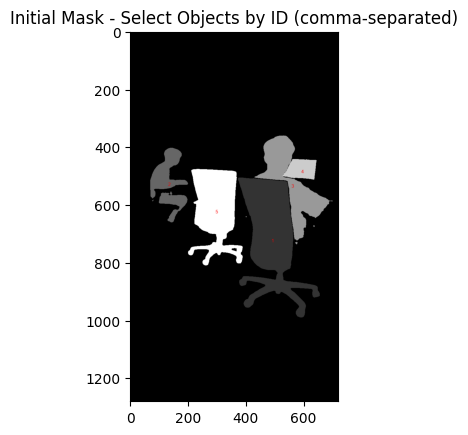

Initializing BaseSegmenter to cuda:0
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


Inpainting image:   0%|          | 0/13 [00:00<?, ?it/s]c:\Users\User\anaconda3\envs\tracking\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Saving object 2 images: 100%|██████████| 214/214 [01:08<00:00,  3.12it/s]


Painted video saved to ./output/object_2\painted_video.mp4
Inpainted video saved to ./output/object_2\inpainted_video.mp4


In [1]:
import cv2
import numpy as np
import torch
import psutil
import shutil
from tqdm import tqdm
import os
from PIL import Image, ImageDraw, ImageFont
from tools.interact_tools import SamControler
from tracker.base_tracker import BaseTracker
from inpainter.base_inpainter import BaseInpainter
from matplotlib import pyplot as plt
from segment_anythingss import sam_model_registry, SamPredictor
from metaseg import sahi_sliced_predict

class TrackingAnything:
    def __init__(self, sam_checkpoint, xmem_checkpoint, e2fgvi_checkpoint, args):
        self.args = args
        self.sam_checkpoint = sam_checkpoint
        self.xmem_checkpoint = xmem_checkpoint
        self.e2fgvi_checkpoint = e2fgvi_checkpoint
        self.samcontroler = SamControler(self.sam_checkpoint, args.sam_model_type, args.device)
        self.xmem = BaseTracker(self.xmem_checkpoint, device=args.device)
        self.baseinpainter = BaseInpainter(self.e2fgvi_checkpoint, args.device)

    def generator(self, images: list, template_mask: np.ndarray):
        masks, logits, painted_images = [], [], []
        for i in tqdm(range(len(images)), desc="Tracking image"):
            if i == 0:
                mask, logit, painted_image = self.xmem.track(images[i], template_mask)
            else:
                mask, logit, painted_image = self.xmem.track(images[i])
            masks.append(mask)
            logits.append(logit)
            painted_images.append(painted_image)
            # torch.cuda.empty_cache()
        return masks, logits, painted_images

class Args:
    device = 'cuda:0'
    sam_model_type = 'vit_h'
    port = 6080
    debug = False
    mask_save = False

args = Args()

def select_objects(initial_mask):
    unique_objects = np.unique(initial_mask)
    unique_objects = unique_objects[unique_objects != 0]
    print(f"Detected objects in initial mask: {unique_objects}")

    # Create an RGB image from the initial mask
    mask_rgb = np.stack([initial_mask]*3, axis=-1)
    mask_rgb = (mask_rgb / mask_rgb.max() * 255).astype(np.uint8)

    # Create a PIL Image from the mask
    mask_pil = Image.fromarray(mask_rgb)
    draw = ImageDraw.Draw(mask_pil)

    # Use a basic font
    try:
        font = ImageFont.truetype("arial.ttf", 32)
    except IOError:
        font = ImageFont.load_default()

    # Draw object IDs on the image
    for obj_id in unique_objects:
        # Find the centroid of the object to place the text
        y, x = np.where(initial_mask == obj_id)
        centroid = (int(x.mean()), int(y.mean()))
        draw.text(centroid, str(obj_id), fill=(255, 0, 0), font=font)

    plt.imshow(mask_pil)
    plt.title('Initial Mask - Select Objects by ID (comma-separated)')
    plt.show()

    selected_object_ids = list(map(int, input(f"Enter the object IDs to track from {unique_objects} (comma-separated): ").split(',')))
    return selected_object_ids

def get_frames_from_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if psutil.virtual_memory().percent > 90:
                print("Memory usage is too high (>90%). Please reduce the video resolution or frame rate.")
                break
        else:
            break
    cap.release()
    return frames, fps

def generate_unique_colors(num_colors):
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(num_colors, 3), dtype=np.uint8)
    return colors

def generate_unique_ids(num_objects):
    return list(range(1, num_objects + 1))

def process_frame_with_sahi(predictor, frame_path, detection_model_path):
    boxes = sahi_sliced_predict(
        image_path=frame_path,
        detection_model_type="yolov8",
        detection_model_path=detection_model_path,
        conf_th=0.5,
        image_size=640,
        slice_height=256,
        slice_width=256,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2
    )

    image = cv2.imread(frame_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    combined_color_mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    unique_ids = generate_unique_ids(len(boxes))
    unique_colors = generate_unique_colors(len(boxes))

    for box, object_id, color in zip(boxes, unique_ids, unique_colors):
        masks, _, _ = predictor.predict(
            point_coords=None, point_labels=None, box=np.array([box])[None, :], multimask_output=False
        )
        masks = masks.cpu().numpy() if isinstance(masks, torch.Tensor) else masks
        mask_image_np = masks[0] if masks.ndim == 3 else np.zeros_like(image[:, :, 0], dtype=np.uint8)
        
        combined_mask[mask_image_np > 0] = object_id
        combined_color_mask[mask_image_np > 0] = color

    return combined_mask, combined_color_mask

if __name__ == "__main__":
    frames, fps = get_frames_from_video("./input/video1.mp4")

    temp_frames_dir = './input/frames'
    temp_masks_dir = './input/masks'
    temp_color_masks_dir = './input/color_masks'
    inpainted_dir = './output/inpainted_frames'

    sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
    xmem_checkpoint = './checkpoints/XMem-s012.pth'
    e2fgvi_checkpoint = './checkpoints/E2FGVI-HQ-CVPR22.pth'

    for dir_path in [temp_frames_dir, temp_masks_dir, temp_color_masks_dir, inpainted_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    for i, frame in tqdm(enumerate(frames), desc="Saving original frames", total=len(frames)):
        frame_path = os.path.join(temp_frames_dir, f'{i:05d}.png')
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imwrite(frame_path, bgr_frame)
    
    if frames:
        sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to(device=args.device)
        predictor = SamPredictor(sam)
        
        first_frame = frames[0]
        first_frame_path = os.path.join(temp_frames_dir, '00000.png')
        cv2.imwrite(first_frame_path, cv2.cvtColor(first_frame, cv2.COLOR_RGB2BGR))

        mask_np, color_mask_np = process_frame_with_sahi(predictor, first_frame_path, "./checkpoints/yolov8n.pt")
        mask_np = cv2.resize(mask_np, (first_frame.shape[1], first_frame.shape[0]))
        color_mask_np = cv2.resize(color_mask_np, (first_frame.shape[1], first_frame.shape[0]))
        
        cv2.imwrite(os.path.join(temp_color_masks_dir, '00000.png'), color_mask_np)
        # torch.cuda.empty_cache()

    initial_mask = mask_np
    selected_object_ids = select_objects(initial_mask)

    for selected_object_id in selected_object_ids:
        selected_mask = (initial_mask == selected_object_id).astype(np.uint8)

        trackany = TrackingAnything(sam_checkpoint, xmem_checkpoint, e2fgvi_checkpoint, args)
        masks, logits, painted_images = trackany.generator(frames, selected_mask)
        # torch.cuda.empty_cache()
        
        frames_np, masks_np = np.array(frames), np.array(masks)
        inpainted_frames = trackany.baseinpainter.inpaint(frames_np, masks_np, ratio=1, dilate_radius=15)
        # torch.cuda.empty_cache()

        object_save_dir = f'./output/object_{selected_object_id}'
        painted_save_dir = os.path.join(object_save_dir, 'painted_images')
        mask_save_dir = os.path.join(object_save_dir, 'masks')
        inpainted_save_dir = os.path.join(object_save_dir, 'inpainted_frames')

        for dir_path in [object_save_dir, painted_save_dir, mask_save_dir, inpainted_save_dir]:
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)
            os.makedirs(dir_path, exist_ok=True)
        
        painted_images_bgr, inpainted_images = [], []

        for i, (mask, painted_image, inpainted_image) in tqdm(enumerate(zip(masks, painted_images, inpainted_frames)), desc=f"Saving object {selected_object_id} images", total=len(frames)):
            painted_filename = os.path.join(painted_save_dir, f"{i:05d}.png")
            mask_filename = os.path.join(mask_save_dir, f'{i:05d}.png')
            inpainted_filename = os.path.join(inpainted_save_dir, f'{i:05d}.png')

            Image.fromarray(painted_image).save(painted_filename)
            Image.fromarray(inpainted_image).save(inpainted_filename)
            white_bg_mask_img = np.where((mask * 255)[..., None], 255, 0).astype(np.uint8)[..., 0]
            Image.fromarray(white_bg_mask_img).save(mask_filename)

            painted_images_bgr.append(cv2.cvtColor(painted_image, cv2.COLOR_RGB2BGR))
            inpainted_images.append(cv2.cvtColor(inpainted_image, cv2.COLOR_RGB2BGR))

        painted_video_path = os.path.join(object_save_dir, 'painted_video.mp4')
        inpainted_video_path = os.path.join(object_save_dir, 'inpainted_video.mp4')
        height, width = painted_images_bgr[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video1, video2 = cv2.VideoWriter(painted_video_path, fourcc, fps, (width, height)), cv2.VideoWriter(inpainted_video_path, fourcc, fps, (width, height))

        for painted_frame, inpainted_frame in zip(painted_images_bgr, inpainted_images):
            video1.write(painted_frame)
            video2.write(inpainted_frame)

        video1.release()
        video2.release()
        print(f"Painted video saved to {painted_video_path}")
        print(f"Inpainted video saved to {inpainted_video_path}")

    torch.cuda.empty_cache()
